# 1. Imports

In [36]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
import glob
from moviepy.editor import VideoFileClip
from functools import reduce
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from PIL import Image
print("done")

done


In [37]:
# carspng = glob.glob('./vehicles/**/*.png', recursive=True)
# notcarspng = glob.glob('./non-vehicles/**/*.png', recursive=True)

# for i in range(0, len(carspng)):
#     car = cars[i]
#     im = Image.open(car)
#     rgb_im = im.convert('RGB')
#     s = './carjpg/car'+ str(i) + '.jpg'
#     print(s)
#     rgb_im.save(s)
# print("Done")
# print(notcarspng)
# for i in range(0, len(notcarspng)):
#     car = notcarspng[i]
#     im = Image.open(car)
#     rgb_im = im.convert('RGB')
#     s = './notcarsjpg/notcar'+ str(i) + '.jpg'
#     print(s)
#     rgb_im.save(s)

cars = glob.glob('./carjpg/**/*.jpg', recursive=True)
notcars = glob.glob('./notcarsjpg/**/*.jpg', recursive=True)


In [38]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [39]:
def extract_features(imgs, color_space='RGB',orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [40]:
def single_img_features(img, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [41]:

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,  
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [42]:

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [43]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [44]:
def slide_window(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
    
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [45]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap



In [46]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 3)
    # Return the image
    return img

In [47]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [48]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 3:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-3:]


In [49]:
  
def find_cars(img, plot=False, filename="final_pipeline_res.png"):
    windows = []
    draw_image = np.copy(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    
    #creating a window for small vehicles in the upper part of the image
    windows = slide_window(img, 400, 416, 1., 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None)
    #creating a bigger window size for closer cars
    windows.extend(slide_window(img, 416, 480, 1., 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    #creating a bigger window for much closer cars
    windows.extend(slide_window(img, 400, 496, 1.5, 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    windows.extend(slide_window(img, 432, 528, 1.5, 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    windows.extend(slide_window(img, 432, 560, 2., 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    windows.extend(slide_window(img, 400, 560, 2., 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    windows.extend(slide_window(img, 400, 596, 3.5, 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    windows.extend(slide_window(img, 464, 660, 3.5, 'YUV', 'ALL', svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

    
    curr_window = search_windows(img, windows, svc, X_scaler, color_space=color_space,  
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)                       

    window_img = draw_boxes(draw_image, curr_window, color=(255, 0, 0), thick=6)     
    

#     # Add heat to each box in box list
#     heat = add_heat(heat, curr_window)      
       
#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat, 3)
    
#     # Visualize the heatmap when displaying 
#     heatmap = np.clip(heat, 0, 255)
    
    # add detections to the history
    if len(curr_window) > 0:
        det.add_rects(curr_window)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 8 + len(det.prev_rects)//4)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
#     heatmap_img = np.zeros_like(img[:,:,0])
#     heatmap_img = add_heat(heatmap_img, rectangles)
#     heatmap_img = apply_threshold(heatmap_img, 1.5)
#     labels = label(heatmap_img)
#     draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)


    heat_rgb = np.uint8(np.dstack((heat, heat, heat)))
    result = cv2.addWeighted(draw_img, 1.0, heat_rgb, 0.8, 0.5)

     
    
     
    
    if plot:
        figure = plt.figure(figsize=(20,10))
        plt.subplot(141)
        plt.imshow(img)
        plt.title("Original image")
        plt.subplot(142)
        plt.imshow(window_img)
        plt.title("Detections image")
        plt.subplot(143)
        plt.imshow(heatmap_img, cmap='hot')
        plt.title("Heatmap image")
        plt.subplot(144)
        plt.title("Labeled detections image")
        plt.imshow(draw_img)
        plt.savefig("./output_imgs/" + filename)
        plt.show()
        
    
    return result

In [50]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

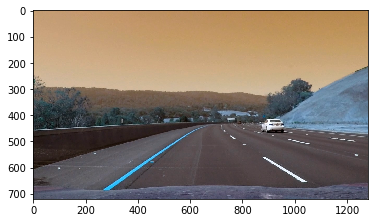

In [51]:
immg = mpimg.imread('./test_images/test3.jpg')
immg = cv2.cvtColor(immg,cv2.COLOR_RGB2BGR)
plt.imshow(immg)
plt.show()


In [52]:

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
y_start_stop = [500, None] # Min and max in y to search in slide_window()
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


NameError: name 'hog_feat' is not defined

In [53]:
det = Vehicle_Detect()
test1 = mpimg.imread('./test_images/test1.jpg')
test2 = mpimg.imread('./test_images/test2.jpg')
test3 = mpimg.imread('./test_images/test3.jpg')
test4 = mpimg.imread('./test_images/test4.jpg')
test5 = mpimg.imread('./test_images/test5.jpg')
test6 = mpimg.imread('./test_images/test6.jpg')

print("Image test1.jpg")
_ = find_cars(test1, plot=True, filename="final_pipeline_test1.png")

print("Image test2.jpg")
_ = find_cars(test2, plot=True, filename="final_pipeline_test2.png")

print("Image test3.jpg")
_ = find_cars(test3, plot=True, filename="final_pipeline_test3.png")

print("Image test4.jpg")
_ = find_cars(test4, plot=True, filename="final_pipeline_test4.png")

print("Image test5.jpg")
_ = find_cars(test5, plot=True, filename="final_pipeline_test5.png")

print("Image test6.jpg")
_ = find_cars(test6, plot=True, filename="final_pipeline_test6.png")



Image test1.jpg


NameError: name 'svc' is not defined

In [167]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

det = Vehicle_Detect()

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_cars)
white_output = "project_video_output.mp4"
%time white_clip.write_videofile(white_output,audio = False)


HTML("""<video width ="960" height ="540" controls> 
<source src ="{0}"> 
</video>""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [15:00<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 8s, sys: 1min 12s, total: 14min 20s
Wall time: 15min 1s
